In [1]:
import os
import numpy as np
import pandas as pd
from keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_and_prepare_data(base_dir, max_sequence_length=None):
    sequences = []
    labels = []

    for label_dir in ['true', 'false']:
        label_path = os.path.join(base_dir, label_dir)
        label = 1 if label_dir == 'true' else 0  # true 디렉토리 1, false 디렉토리 0

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if file_name.endswith('.txt'):
                data = pd.read_csv(file_path, delimiter=',')
                
                sequences.append(data.values)
                labels.append(label)

    # 시퀀스 길이 맞추기 (패딩추가)
    if max_sequence_length is None:
        max_sequence_length = max(len(seq) for seq in sequences)
    
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

    return np.array(padded_sequences), np.array(labels), max_sequence_length

In [3]:
def create_sliding_windows(data, labels, window_size, stride=1):
    num_samples = data.shape[0]
    num_timesteps = data.shape[1]
    num_features = data.shape[2]
    
    windows = []
    window_labels = []

    for i in range(num_samples):
        for start in range(0, num_timesteps - window_size + 1, stride):
            end = start + window_size
            window = data[i, start:end, :]
            windows.append(window)
            window_labels.append(labels[i])
    
    return np.array(windows), np.array(window_labels)

In [4]:
# 데이터셋 불러오기
base_dir = './training_data'
X, y, max_len = load_and_prepare_data(base_dir)

# 슬라이딩 윈도우 적용
window_size = 100
X_windows, y_windows = create_sliding_windows(X, y, window_size)

print("Original:", X.shape)
print("after x_windows:", X_windows.shape)
print("after y_windows:", y_windows.shape)

Original: (205, 19999, 6)
after x_windows: (4079500, 100, 6)
after y_windows: (4079500,)


In [6]:
def generator(X, y, window_size):
    for i in range(len(y)):
        yield X[i], y[i]

dataset = tf.data.Dataset.from_generator(
    lambda: generator(X_windows, y_windows, window_size),
    output_signature=(
        tf.TensorSpec(shape=(window_size, X_windows.shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
)

In [7]:
dataset = dataset.shuffle(buffer_size=512).batch(512).prefetch(tf.data.AUTOTUNE)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

# 검증 데이터셋 생성
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(512)

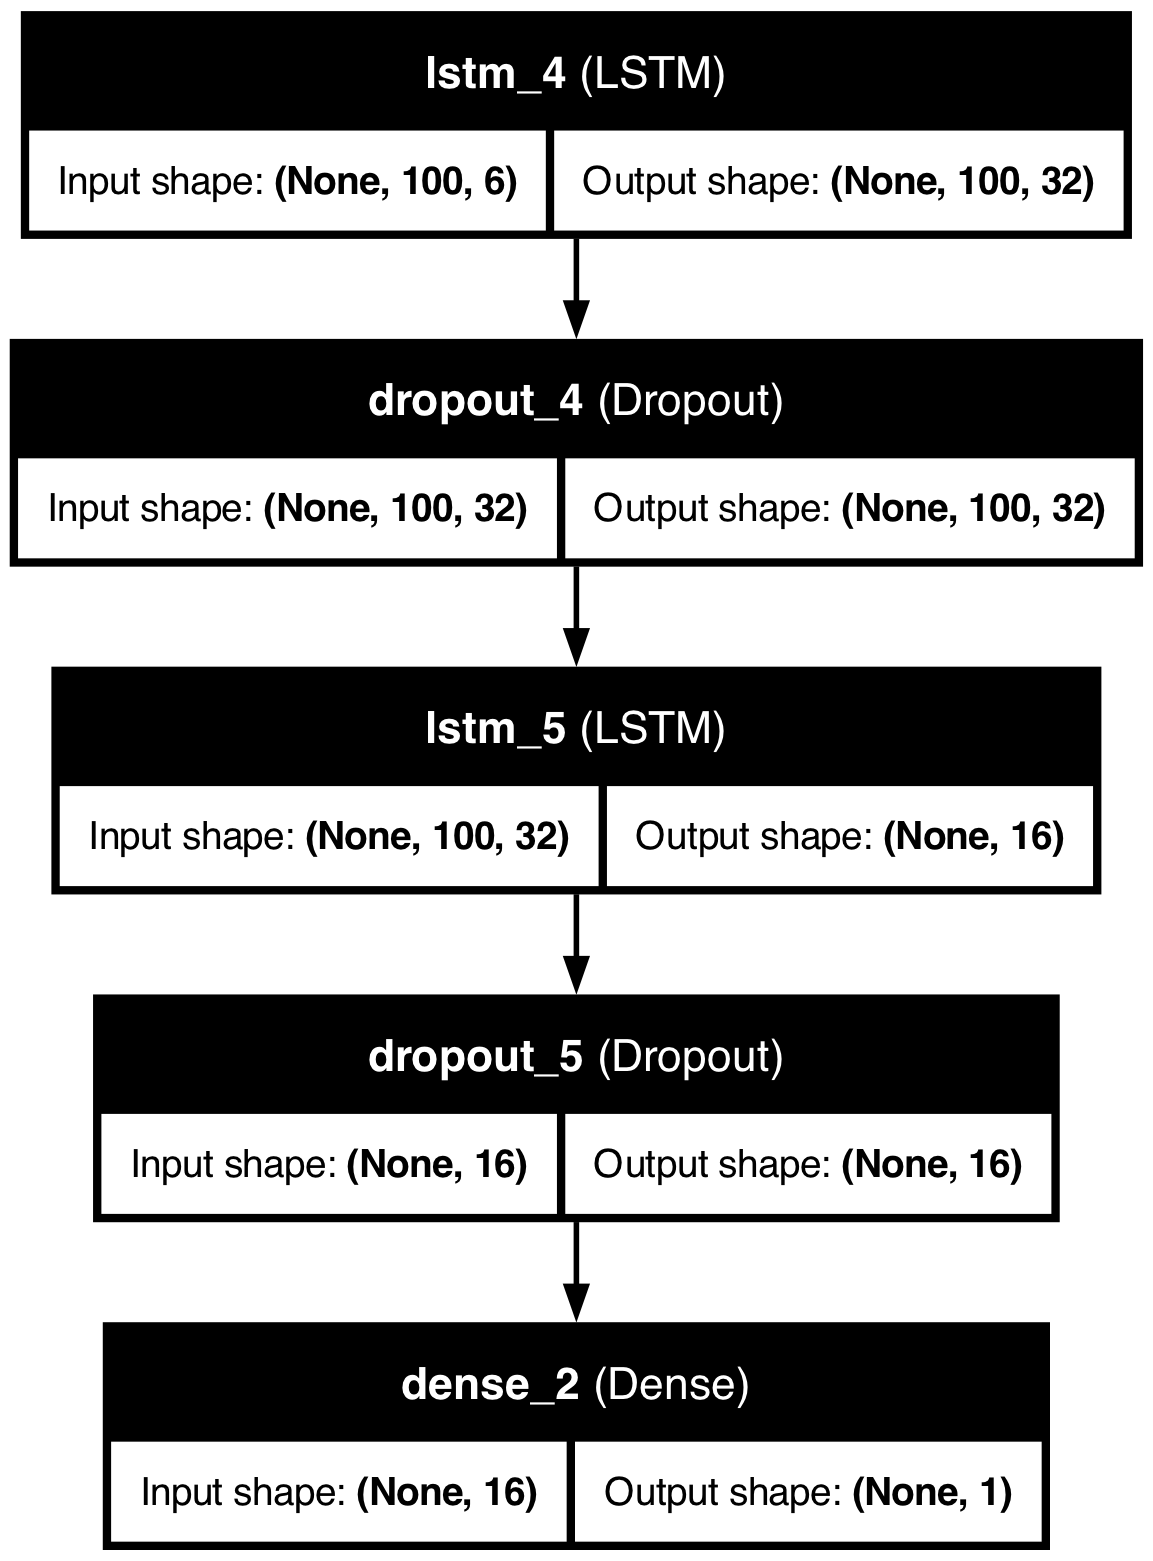

In [14]:
model = Sequential()
model.add(Input(shape=(window_size, X_windows.shape[2])))  # Input 레이어를 명시적으로 추가
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))  
model.add(LSTM(16, return_sequences=False)) 
model.add(Dropout(0.3)) 
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(dataset, 
                    epochs=15, 
                    validation_data=val_dataset)

Epoch 1/15
   7968/Unknown 1462s 183ms/step - accuracy: 0.9963 - loss: 0.0271

2024-08-11 21:19:18.072693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 1562s 196ms/step - accuracy: 0.9963 - loss: 0.0271 - val_accuracy: 0.3908 - val_loss: 6.0706
Epoch 2/15
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9782 - loss: 0.1202

2024-08-11 21:45:21.046326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 1567s 197ms/step - accuracy: 0.9782 - loss: 0.1202 - val_accuracy: 0.3915 - val_loss: 5.9569
Epoch 3/15
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9774 - loss: 0.1216

2024-08-11 22:11:01.708343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 1534s 193ms/step - accuracy: 0.9774 - loss: 0.1215 - val_accuracy: 0.3916 - val_loss: 5.5094
Epoch 4/15
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9735 - loss: 0.1559

2024-08-11 22:36:19.352377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 1521s 191ms/step - accuracy: 0.9735 - loss: 0.1559 - val_accuracy: 0.3934 - val_loss: 6.3191
Epoch 5/15
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9757 - loss: 0.1657

2024-08-11 23:02:03.248877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 1542s 194ms/step - accuracy: 0.9757 - loss: 0.1657 - val_accuracy: 0.3956 - val_loss: 6.5269
Epoch 6/15
4042/7968 ━━━━━━━━━━━━━━━━━━━━ 11:48 180ms/step - accuracy: 0.9605 - loss: 0.2519